In [1]:
import sys
import numpy
import matplotlib.pyplot as plt, pandas as pd, matplotlib as mpl, random
import h5py
import numpy as np
import ast
from scipy.ndimage import gaussian_filter
from matplotlib.colors import ListedColormap
import corner

def utkarshGrid(): plt.minorticks_on() ; plt.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; plt.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
def utkarshGridAX(ax): ax.minorticks_on() ; ax.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; ax.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
mpl.rcParams['legend.frameon'], mpl.rcParams['figure.autolayout'] = False, True,
colour = ["dodgerblue", "goldenrod", "crimson", "teal", "yellowgreen", "grey"]
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Palatino"],})
def utkarshWrapper(): plt.legend();plt.utkarshGrid() ;plt.gca().tick_params(direction='in', which='both', right=True, top=True); plt.tight_layout(); return None
def utkarshWrapperAX(ax): utkarshGridAX(ax); ax.tick_params(direction='in', which='both', right=True, top=True); return None;
plt.utkarshGrid = utkarshGrid; plt.utkarshWrapper = utkarshWrapper
def colour_sample(n = 2, col = colour, seed = 7236): random.seed(seed) ; return random.sample(colour, n)
plt.rcParams["image.cmap"] = "Set2" # I recommend, Set2, Dark2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colour) # Use your own OR plt.cm.Set2.colors

In [2]:
from astropy.cosmology import Planck18
from astropy.cosmology import z_at_value
import astropy.units as u
import numpy.lib.recfunctions as rfn

def det_to_src_mass(m_det, d_l_mpc, cosmo=Planck18, zmax=20):
    m_det = np.asarray(m_det) * u.Msun
    d_l_mpc = np.asarray(d_l_mpc)
    m_det, d_l_mpc = np.broadcast_arrays(m_det, d_l_mpc)
    z = np.vectorize(lambda dl: z_at_value(cosmo.luminosity_distance, dl * u.Mpc, zmax=zmax))(d_l_mpc)
    m_src = m_det / (1.0 + z)
    return m_src, z

def read_event(path):
    with h5py.File(path, "r") as f:
        data = {}
        for key in f.keys():
            try:
                data[key] = f[key][:]
            except:
                data[key] = f[key][()]
    return data

def _event(path):
    with h5py.File(path, "r") as f:
        data = {}
        for key in f.keys():
            if "history" in key: continue
            if "version" in key: continue
            if "prior" in key: continue
            try:
                data[key] = f[key]["posterior_samples"][:]
            except:
                data[key] = f[key]["posterior_samples"][()]
    return data

In [55]:
GW170817_path = "../../data/events_of_interest/GW170817_GWTC-1.hdf5"
GW190425_path = "../../data/events_of_interest/IGWN-GWTC2p1-v2-GW190425_081805_PEDataRelease_mixed_nocosmo.h5"
GW190814_path = "../../data/events_of_interest/IGWN-GWTC2p1-v2-GW190814_211039_PEDataRelease_mixed_nocosmo.h5"
GW200115_path = "../../data/events_of_interest/IGWN-GWTC3p0-v2-GW200115_042309_PEDataRelease_mixed_nocosmo.h5"
GW230529_path = "../../data/events_of_interest/IGWN-GWTC4p0-v0-GW230529_181500_PEDataRelease_mixed_cosmo.h5"

GW170817 = read_event(GW170817_path)["IMRPhenomPv2NRT_highSpin_posterior"]
m1, z = det_to_src_mass(GW170817["m1_detector_frame_Msun"], GW170817["luminosity_distance_Mpc"])
m2, _ = det_to_src_mass(GW170817["m2_detector_frame_Msun"], GW170817["luminosity_distance_Mpc"])
GW170817 = rfn.append_fields( GW170817,["mass_1_source", "mass_2_source", "redshift"],[m1, m2, z],usemask=False)

In [61]:
GW190425 = _event(GW190425_path)["C01:IMRPhenomPv2_NRTidal:HighSpin"]
GW190814 = _event(GW190814_path)["C01:Mixed"]
GW200115 = _event(GW200115_path)["C01:Mixed"]
GW230529 = _event(GW230529_path)["combined_imrphm_high_spin"]

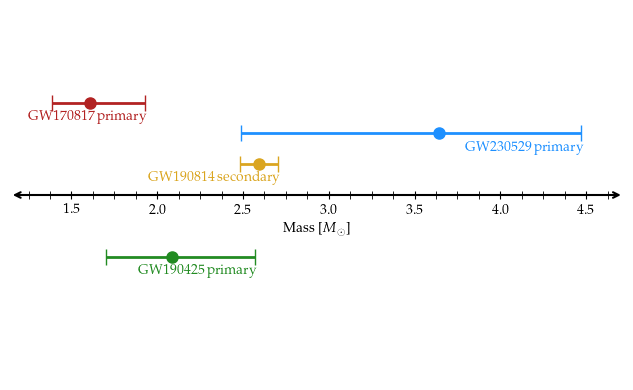

In [104]:
import numpy as np
import matplotlib.pyplot as plt

def pct(x, p):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    return np.percentile(x, p)

labels  = ["GW170817 primary", "GW230529 primary", "GW190814 secondary", "GW190425 primary"]
samples = [GW170817["mass_1_source"], GW230529["mass_1_source"], GW190814["mass_2_source"], GW190425["mass_1_source"]]
y       = np.array([1.5, 1, 0.5, -1.0, -1.5])

event_colors = {
    "GW170817 primary":  "firebrick",
    "GW230529 primary":"#1e90ff",
    "GW190814 secondary":  "#daa520",
    "GW190425 primary": "#228B22",
}


low  = np.array([pct(s, 5)  for s in samples])
med  = np.array([pct(s, 50) for s in samples])
high = np.array([pct(s, 95) for s in samples])

fig, ax = plt.subplots(figsize=(6.5, 4))
for lab, yi, lo, me, hi in zip(labels, y, low, med, high):

    # if "GW190814" in lab:
    #     continue
    # if "GW230529" in lab:
    #     continue
    # if "GW190425" in lab:
    #     continue

    c = event_colors.get(lab, "C0")
    ax.errorbar(
        me, yi,
        xerr=[[me - lo], [hi - me]],
        fmt='o', ms=8, lw=2, capsize=6, color=c, ecolor=c
    )
    xr = (high.max() - low.min())
    ax.text(hi + 0.005*xr, yi - 0.12, lab, color=c, fontsize=10,
            ha='right', va='top')

ax.set_yticks([]); ax.set_yticklabels([])
ax.set_xlabel(r"Mass [$M_\odot$]")

pad = 0.08 * (high.max() - low.min())
xmin, xmax = low.min() - pad, high.max() + pad
ax.set_xlim(xmin, xmax)
ax.set_ylim(-3, 3)
ax.set_xlim(xmin, xmax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position(('axes', 0.5))
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax.xaxis.set_ticks_position('bottom')

# double-headed arrow along the bottom axis
ax.annotate(
    "", xy=(xmax, 0.5), xytext=(xmin, 0.5),
    xycoords=('data', 'axes fraction'), textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', lw=1.5)
)

ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='x', which='both', direction='inout', length=6)
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(n=4))  # n=4 → 4 minor intervals between majors
ax.tick_params(axis='x', which='major', labelbottom=True)

plt.tight_layout()
plt.savefig("presentation_plots/event_masses.png", dpi=300)
plt.show()


In [199]:
# Add turnoff filter after 4 solar masses
reweighed_GW230529m1 = np.array(np.load("corner_params.npy")).flatten()
reweighed_GW230529m1 = reweighed_GW230529m1[reweighed_GW230529m1 <= 5.0]

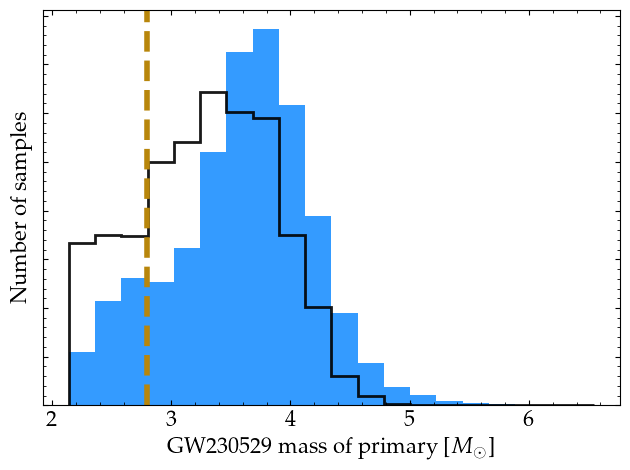

In [203]:
data1 = reweighed_GW230529m1
data2 = GW230529["mass_1_source"]

bins = np.linspace(min(data1.min(), data2.min()), max(data1.max(), data2.max()), 21)

plt.figure()
plt.hist(GW230529["mass_1_source"],bins=bins, density=True, histtype="stepfilled",alpha=0.9, color="dodgerblue", label="GW230529 primary")
plt.hist(reweighed_GW230529m1, bins=bins, density=True, histtype="step", linewidth=2, color="black", alpha=0.9, label="Reweighted GW230529")

ax = plt.gca()
ax.tick_params(direction="in", which="both", top=True, right=True)
ax.set_yticklabels([])
ax.minorticks_on()
label="Maximum mass of a Neutron Star from EOS constraints"
plt.axvline(x=2.8, color="darkgoldenrod", linewidth=4, linestyle="--", label=label)
# ax.grid(which="minor", linestyle=":", linewidth=0.7, alpha=0.7)
plt.ylabel("Number of samples", fontsize=16)
plt.xlabel(r"GW230529 mass of primary [$M_\odot$]", fontsize=16)
ax.tick_params(axis="x", labelsize=16)

plt.savefig("presentation_plots/GW230529_mass1.png", dpi=300)
plt.show()
